In [38]:
!nvidia-smi

Sat May  8 08:02:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [40]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Utility
import numpy as np
import pandas as pd
import re
import time
import pickle
import itertools

# Word2vec
import gensim

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [41]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [81]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [67]:
df = pd.read_csv('/content/gdrive/MyDrive/Data/SentimentAnalysis/training.1600000.processed.noemoticon.csv',
                 engine='python',
                 names = DATASET_COLUMNS)
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [68]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [69]:
df.target = df.target.apply(lambda x: decode_sentiment(x))

In [70]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [71]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [72]:
df.text = df.text.apply(lambda z: preprocess(z))

In [73]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [74]:
df_train.head(5)

,target,ids,date,flag,user,text
1374558,POSITIVE,2051457557,Fri Jun 05 22:04:23 PDT 2009,NO_QUERY,JGoldsborough,ya quot like palm pre touchstone charger ready...
1389115,POSITIVE,2053083567,Sat Jun 06 03:12:21 PDT 2009,NO_QUERY,Psioui,felt earthquake afternoon seems epicenter
1137831,POSITIVE,1976779404,Sat May 30 19:02:49 PDT 2009,NO_QUERY,adriville,ruffles shirts like likey
790714,NEGATIVE,2325739990,Thu Jun 25 05:59:18 PDT 2009,NO_QUERY,Blondie128,pretty bad night crappy morning fml buttface d...
1117911,POSITIVE,1973503391,Sat May 30 11:16:35 PDT 2009,NO_QUERY,khrabrov,yeah clear view


In [75]:
documents = [_text.split() for _text in df_train.text] 

In [76]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [77]:
w2v_model.build_vocab(documents)

In [78]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 290418


In [79]:
words

dict_keys(['ya', 'quot', 'like', 'palm', 'pre', 'touchstone', 'charger', 'readynow', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch', 'felt', 'earthquake', 'afternoon', 'seems', 'epicenter', 'ruffles', 'shirts', 'likey', 'pretty', 'bad', 'night', 'crappy', 'morning', 'fml', 'buttface', 'didnt', 'say', 'could', 'go', 'work', 'today', 'yeah', 'clear', 'view', 'one', 'time', 'follow', 'fam', 'ff', 'georgeann13', 'nakithebeatman', 'flimackgod', 'chaz81', 'djt', 'elle', 'jaejaedynomite', 'welcome', 'friday', '2', 'u', 'rock', 'thanks', 'added', 'next', 'robcrotch', 'tm', 'video', 'please', 'met', 'fiancee', 'ian', 'party', 'day', 'btw', 'sweet', 'congrats', 'guys', 'gawd', 'finished', 'whole', 'bowl', 'even', 'posted', 'previous', 'tweet', 'making', '2nd', 'awesome', 'game', 'short', 'finish', 'craving', 'god', 'war', 'action', 'happy', 'mothers', 'grown', 'n', 'amp', 'lil', 'prego', 'smuts', 'lol', 'playing', 'everyone', 'loved', 'bless', 'back', 'eating', 'dinner', 'chat', 'room', '

In [56]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

KeyboardInterrupt: ignored

In [ ]:
w2v_model.most_similar("love")

In [80]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
embedding_matrix = np.zeros([vocab_size, W2V_SIZE])
for word,idx in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 540s 475ms/step - loss: 0.5263 - accuracy: 0.7334 - val_loss: 0.4672 - val_accuracy: 0.7768
Epoch 2/8
1125/1125 [==============================] - 532s 473ms/step - loss: 0.4798 - accuracy: 0.7667 - val_loss: 0.4576 - val_accuracy: 0.7834
Epoch 3/8
1125/1125 [==============================] - 532s 473ms/step - loss: 0.4711 - accuracy: 0.7722 - val_loss: 0.4556 - val_accuracy: 0.7859
Epoch 4/8
1125/1125 [==============================] - 533s 474ms/step - loss: 0.4676 - accuracy: 0.7748 - val_loss: 0.4514 - val_accuracy: 0.7873
Epoch 5/8
1125/1125 [==============================] - 532s 473ms/step - loss: 0.4644 - accuracy: 0.7769 - val_loss: 0.4480 - val_accuracy: 0.7886
Epoch 6/8
1125/1125 [==============================] - 531s 472ms/step - loss: 0.4633 - accuracy: 0.7770 - val_loss: 0.4465 - val_accuracy: 0.7898
Epoch 7/8
1125/1125 [==============================] - 531s 472ms/step - loss: 0.4619 - accuracy: 0.7782 - val_loss: 0

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 47s 148ms/step - loss: 0.4464 - accuracy: 0.7912

ACCURACY: 0.7912468910217285
LOSS: 0.446353018283844


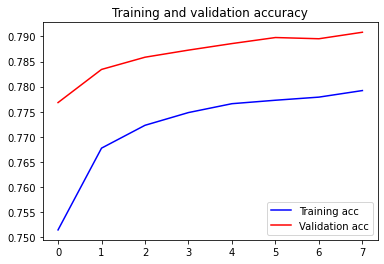

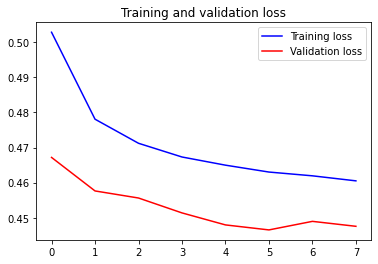

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

{'elapsed_time': 0.2951090335845947,
 'label': 'POSITIVE',
 'score': 0.975832462310791}

In [ ]:
predict("I hate the rain")

{'elapsed_time': 0.08852458000183105,
 'label': 'NEGATIVE',
 'score': 0.009283266961574554}

In [ ]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.0937042236328125,
 'label': 'NEGATIVE',
 'score': 0.2932344675064087}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 37s 875ms/step
CPU times: user 29.4 s, sys: 8.54 s, total: 38 s
Wall time: 37.7 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

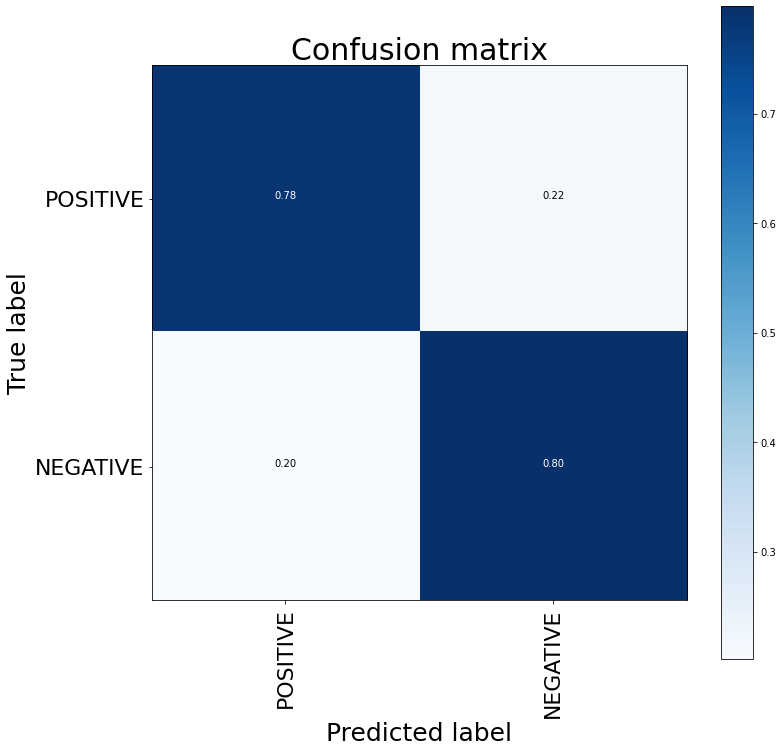

CPU times: user 1.06 s, sys: 13.1 ms, total: 1.08 s
Wall time: 1.07 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.791246875

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)

In [ ]:
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)